In [1]:
%matplotlib inline

In [2]:
# Make sure the notebook is run in the root dir of the repository
%cd ..

/home/afr/Documents/workspace/projects/scifiRNA-seq_publication


In [3]:
import os
from functools import partial

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import numpy as np
from tqdm import tqdm


In [4]:
sns.set(context="paper", style="ticks", palette="colorblind", color_codes=True)
matplotlib.rcParams["svg.fonttype"] = "none"
# Don't use LaTeX for rendering
matplotlib.rcParams["text.usetex"] = False
np.seterr(divide = 'ignore') 

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [5]:
metadata_dir = Path("metadata")
metadata_dir.mkdir(exist_ok=True)
data_dir = Path("data")
data_dir.mkdir(exist_ok=True)
output_dir = Path("results/method_comparison")
output_dir.mkdir(exist_ok=True, parents=True)
output_prefix = (output_dir / "method_comparison.").as_posix()

In [6]:
annot = pd.read_csv(metadata_dir / "annotation.csv")

experiments = annot.loc[
    annot["sample_name"].str.contains("PD200")
    | annot["sample_name"].str.contains("plex")
    | annot["sample_name"].str.startswith("scirna")
    | annot["sample_name"].str.contains("splitseq")
]


In [7]:
def inflection_point(curve):
    """Return the index of the inflection point of a curve"""
    from numpy.matlib import repmat

    n_points = len(curve)
    all_coord = np.vstack((range(n_points), curve)).T
    line_vec = all_coord[-1] - all_coord[0]
    line_vec_norm = line_vec / np.sqrt(np.sum(line_vec ** 2))
    vec_from_first = all_coord - all_coord[0]
    scalar_product = np.sum(
        vec_from_first * repmat(line_vec_norm, n_points, 1), axis=1
    )
    vec_to_line = vec_from_first - np.outer(scalar_product, line_vec_norm)
    return np.argmax(np.sqrt(np.sum(vec_to_line ** 2, axis=1)))

We'll do this for two sets of cell barcodes:

One which is determined by the inflection point of a curve (knee plot)
and for all barcodes with more than 10 UMIs.

In [8]:
# Collect metrics
metrics_a = dict()
metrics_f = dict()
inflex = dict()
for experiment in experiments["sample_name"]:
    print(experiment)
    m = pd.read_csv(data_dir / experiment / (experiment + ".metrics.csv.gz")).sort_values("umi")
    m["umi_read_ratio"] = m["umi"] / m["read"]
    m["gene_umi_ratio"] = m["gene"] / m["umi"]
    m["log_unique_read_ratio"] = np.log2(
        m["unique_fraction"] / (m["read"] / 1e4)
    )
    if "material_type" not in m.columns:
        m.loc[:, "material_type"] = experiments.loc[
            experiments["sample_name"] == experiment, "material"
        ].squeeze()
    m['doublet'] = ((m['sp_ratio'] < 0.75) & (m['sp_ratio'] > 0.25)).astype(int)
    m['doublet_norm'] = ((m['sp_ratio_norm'] < 0.7) & (m['sp_ratio_norm'] > 0.3)).astype(int)
    # m["doublet"] = m["doublet"].replace(-1, 0)
    inflex[experiment] = inflection_point(m["umi"])
    metrics_a[experiment] = m.query("umi > 10")
    metrics_f[experiment] = m.iloc[inflex[experiment] :]

PD200_10xscRNA_nuclei
PD200_10xscRNA_cellsMeOH
PD200_10xscRNA_cells
PD200_1_std
PD200_2_10xbuffer
sciplex_GSE139944
scirna_GSE98561
splitseq_300
splitseq_3000


In [9]:
# tidy up the dfs
metrics_a = (
    pd.concat(metrics_a)
    .reset_index(level=1, drop=True)
    .reset_index()
    .rename(columns={"index": "sample"})
    .sort_values(["sample", "umi"])
)
metrics_f = (
    pd.concat(metrics_f)
    .reset_index(level=1, drop=True)
    .reset_index()
    .rename(columns={"index": "sample"})
    .sort_values(["sample", "umi"])
)

In [10]:
# Let's standardize the sample names
pretty_names = {
    'PD200_10xscRNA_cells': 'Chromium: Intact cells',
    'PD200_10xscRNA_nuclei': 'Chromium: Nuclei',
    'PD200_10xscRNA_cellsMeOH': 'Chromium: MEOH-fixed cells',
    'PD200_1_std': 'scifi-RNA-seq: Nuclei',
    'PD200_2_10xbuffer': 'scifi-RNA-seq: MEOH-fixed cells',
    'splitseq_3000': 'SPLiT-seq (GSM3017262)',
    'splitseq_300': 'SPLiT-seq (GSM3017263)',
    'scirna_GSE98561': 'sci-RNA-seq (GSM2599699)',
    'sciplex_GSE139944': 'sci-Plex (GSM4150376)',
}
for df in [metrics_a, metrics_f]:
    df['sample'] = pd.Categorical(
        df['sample'].replace(pretty_names).values,
        categories=pretty_names.values(),
        ordered=True)

# For direct performance comparisons I select only mouse cells because
# the exact same cell line was used
metrics_fm = metrics_f.query("sp_ratio_norm < 0.5").copy()

In [11]:
metrics_fm.head()

,sample,r1,read,unique_umis,umi,gene,human,mouse,total,max,...,read_doublet_norm,umi_read_ratio,gene_umi_ratio,log_unique_read_ratio,material_type,r2,unique_umi,plate_well,cell_line,r3
9373,Chromium: Intact cells,TCGACGGCAGCCGTCA,327,277.0,304,238,2,304,306,304,...,-1,0.929664,0.782895,4.800089,cells,NaN,NaN,NaN,NaN,NaN
9374,Chromium: Intact cells,ATCATTCAGTCCTGTA,315,290.0,305,226,6,301,307,301,...,-1,0.968254,0.740984,4.916022,cells,NaN,NaN,NaN,NaN,NaN
9375,Chromium: Intact cells,CTCAGTCCAAGTTGGG,324,284.0,306,248,6,302,308,302,...,-1,0.944444,0.810458,4.840059,cells,NaN,NaN,NaN,NaN,NaN
9376,Chromium: Intact cells,CATTCATCAGGACGAT,331,280.0,306,216,8,300,308,300,...,-1,0.924471,0.705882,4.788869,cells,NaN,NaN,NaN,NaN,NaN
9377,Chromium: Intact cells,CGTCCATCAAGAGGTC,318,291.0,306,209,4,304,308,304,...,-1,0.962264,0.683007,4.902347,cells,NaN,NaN,NaN,NaN,NaN


In [12]:
metrics_fm.tail()

,sample,r1,read,unique_umis,umi,gene,human,mouse,total,max,...,read_doublet_norm,umi_read_ratio,gene_umi_ratio,log_unique_read_ratio,material_type,r2,unique_umi,plate_well,cell_line,r3
74247,SPLiT-seq (GSM3017262),CACTTCGA,38284,14273.0,24418,4854,142,24278,24420,24278,...,-1,0.637812,0.198788,-2.710233,cells_and_nuclei,GAATCTGA,NaN,NaN,NaN,AAGGTACA
74259,SPLiT-seq (GSM3017262),ACGTATCA,42171,15359.0,26907,5349,201,26708,26909,26708,...,-1,0.638045,0.198796,-2.884689,cells_and_nuclei,TCCGTCTA,NaN,NaN,NaN,CGCATACA
74273,SPLiT-seq (GSM3017262),AACGCTTA,42917,17510.0,29363,5282,165,29200,29365,29200,...,-1,0.684181,0.179886,-2.848165,cells_and_nuclei,TGGTGGTA,NaN,NaN,NaN,TTCACGCA
74290,SPLiT-seq (GSM3017262),CATCAAGT,54643,20123.0,35265,5917,208,35059,35267,35059,...,-1,0.645371,0.167787,-3.258474,cells_and_nuclei,ACGCTCGA,NaN,NaN,NaN,ACAGATTC
74307,SPLiT-seq (GSM3017262),GGGGGGGG,330985,148160.0,214743,21226,126014,88731,214745,126014,...,1,0.648800,0.098844,-5.584026,cells_and_nuclei,GGGGGGGG,NaN,NaN,NaN,GGGGGGGG


In [13]:
# Make quick summary of all experiments
vars_ = [
    "read",
    "umi",
    "gene",
    "unique_fraction",
    "umi_read_ratio",
    "gene_umi_ratio",
    "log_unique_read_ratio",
    "doublet",
]

p75 = partial(np.percentile, q=75)
p75.__name__ = "75_percentile"
p25 = partial(np.percentile, q=25)
p25.__name__ = "25_percentile"

summary = (
    metrics_fm.query("umi > 100")
    # .nlargest(20000, columns="umi")
    .groupby(["sample", "material_type"])[vars_]
    .agg([p25, np.mean, np.median, p75])
    .T
)
summary.to_csv(output_prefix + "summary.csv")

In [14]:
sns.set_palette(
    sns.color_palette(
        "Paired",
        metrics_fm[["sample", "material_type"]].drop_duplicates().shape[0],
    )
)
fig_kws = dict(dpi=300, bbox_inches="tight")

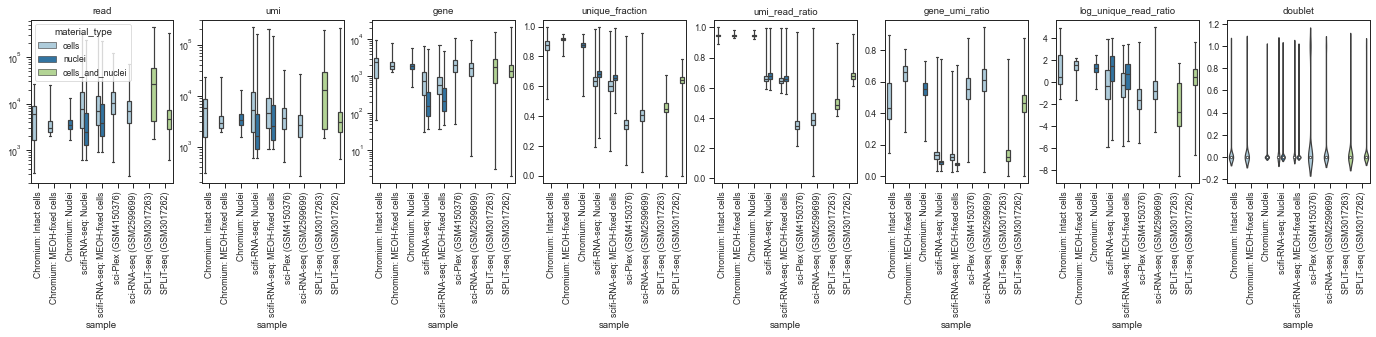

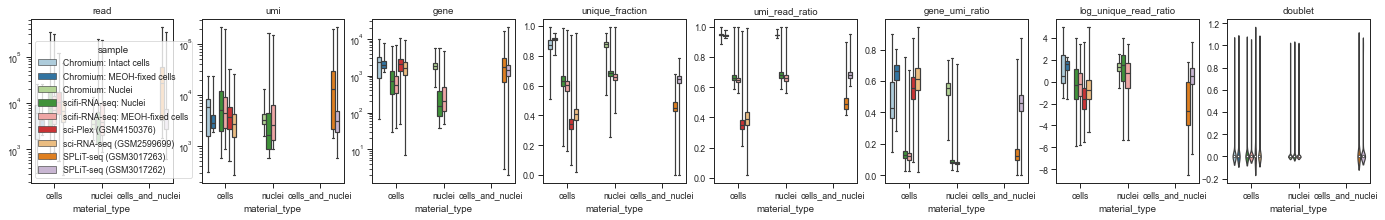

In [15]:
# summary
for label in ["per_sample", "per_material"]:
    fig, axis = plt.subplots(1, len(vars_), figsize=(3 * len(vars_), 3 * 1))
    ax = iter(axis.flatten())
    b_kws = dict(whis=1e9)
    if label == "per_sample":
        b_kws.update(
            dict(
                x="sample",
                hue="material_type",
                order=metrics_fm["sample"].unique(),
                hue_order=metrics_fm["material_type"].unique(),
            )
        )
    else:
        b_kws.update(
            dict(
                x="material_type",
                hue="sample",
                order=metrics_fm["material_type"].unique(),
                hue_order=metrics_fm["sample"].unique(),
            )
        )
    for var_ in vars_[:-1]:
        sns.boxplot(data=metrics_fm, y=var_, ax=next(ax), **b_kws)
    del b_kws["whis"]
    sns.violinplot(data=metrics_fm, y=vars_[-1], ax=next(ax), **b_kws)
    for ax in axis.flatten()[:3]:
        ax.set_yscale("log")
    for t, ax in zip(vars_, axis.flatten()):
        ax.set_title(t)
        ax.set_ylabel(ax.get_ylabel(), visible=False)
    for ax in axis.flatten()[1:]:
        ax.get_legend().set_visible(False)
    if label == "per_sample":
        for ax in axis.flatten():
            ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    fig.savefig(
        output_prefix + f"summary_boxplot.{label}.svg",
        **fig_kws,
    )

In [16]:
def minmax_scale(x, percent=True, add=True):
    return (x - x.min()) / (x.max() - x.min()) * (100 if percent else 1) + (
        1 if add else 0
    )

Let's plot the broad metrics for the samples.

We'll make two versions: one with virtually all cell barcodes, in order to really see the difference between background and "real" barcodes; another version with the barcodes selected as likely real cells where it's more "fair" to compare the different methods.

Chromium: Intact cells cells
Chromium: MEOH-fixed cells cells
Chromium: Nuclei nuclei
scifi-RNA-seq: Nuclei cells
scifi-RNA-seq: Nuclei nuclei
scifi-RNA-seq: MEOH-fixed cells nuclei
scifi-RNA-seq: MEOH-fixed cells cells
sci-Plex (GSM4150376) cells
sci-RNA-seq (GSM2599699) cells
SPLiT-seq (GSM3017263) cells_and_nuclei
SPLiT-seq (GSM3017262) cells_and_nuclei


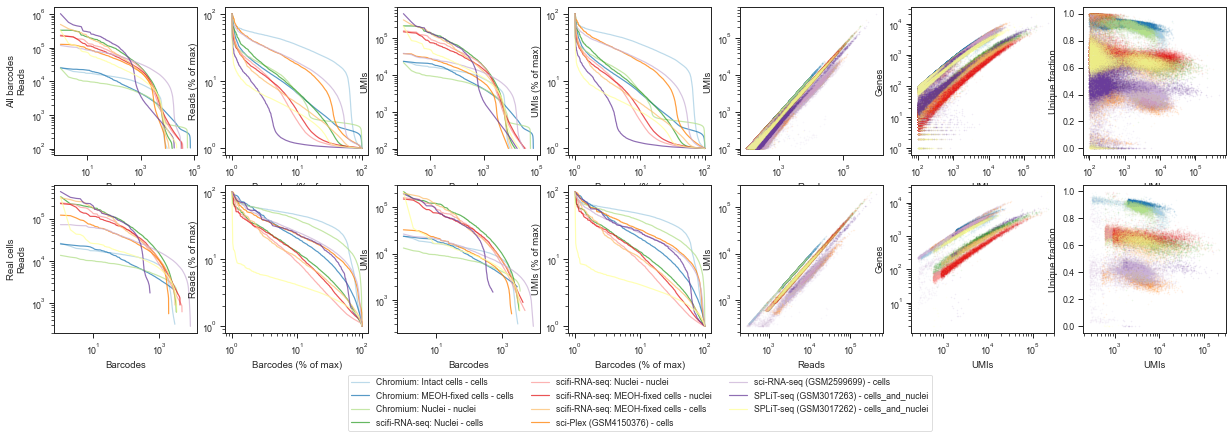

In [17]:
# Illustrations
s = metrics_fm[["sample", "material_type"]].drop_duplicates()
n = s.shape[0]

fig, axis = plt.subplots(2, 7, figsize=(3 * 7, 3 * 2))
for i, (sample, material) in s.iterrows():
    print(sample, material)
    m_a = metrics_a.query(
        f"(sample == '{sample}') & (umi > 100) & (material_type == '{material}')"
    )
    m_f = metrics_fm.query(
        f"(sample == '{sample}') & (material_type == '{material}')"
    )
    for ax, m in zip(axis, (m_a, m_f)):
        kwds = dict(label=sample + " - " + material, alpha=0.75)

        # Read rank vs read
        m = m.sort_values("read")
        rr = m["read"].rank(ascending=False)
        ax[0].plot(rr, m["read"], **kwds)
        ax[0].loglog()
        ax[0].set_xlabel("Barcodes")
        ax[0].set_ylabel("Reads")
        # Read rank vs read (scaled to max)
        ax[1].plot(minmax_scale(rr), minmax_scale(m["read"]), **kwds)
        ax[1].loglog()
        ax[1].set_xlabel(r"Barcodes (% of max)")
        ax[1].set_ylabel(r"Reads (% of max)")
        # UMI rank vs UMI
        m = m.sort_values("umi")
        ur = m["umi"].rank(ascending=False)
        ax[2].plot(ur, m["umi"], **kwds)
        ax[2].loglog()
        ax[2].set_xlabel("Barcodes")
        ax[2].set_ylabel("UMIs")
        # UMI rank vs UMI (scaled to max)
        ax[3].plot(minmax_scale(ur), minmax_scale(m["umi"]), **kwds)
        ax[3].loglog()
        ax[3].set_xlabel(r"Barcodes (% of max)")
        ax[3].set_ylabel(r"UMIs (% of max)")
        # read vs UMI
        kwds = dict(label=sample + " - " + material)
        s_kwds = dict(alpha=0.05, s=1, rasterized=True)
        ax[4].scatter(m["read"], m["umi"], **s_kwds, **kwds)
        ax[4].loglog()
        ax[4].set_xlabel("Reads")
        ax[4].set_ylabel("UMIs")
        # UMI vs Gene
        ax[5].scatter(m["umi"], m["gene"], **s_kwds, **kwds)
        ax[5].loglog()
        ax[5].set_xlabel("UMIs")
        ax[5].set_ylabel("Genes")
        # UMI vs Unique
        ax[6].scatter(m["umi"], m["unique_fraction"], **s_kwds, **kwds)
        ax[6].set_xscale("log")
        ax[6].set_xlabel("UMIs")
        ax[6].set_ylabel("Unique fraction")

axis[1, 3].legend(bbox_to_anchor=(0.5, -0.25), ncol=3, loc="upper center")
axis[0, 0].set_ylabel(
    "All barcodes\n" + axis[0, 0].get_ylabel(), ha="center", va="bottom"
)
axis[1, 0].set_ylabel(
    "Real cells\n" + axis[1, 0].get_ylabel(), ha="center", va="bottom"
)
fig.savefig(
    output_prefix + "joint_comparison.svg",
    **fig_kws,
)


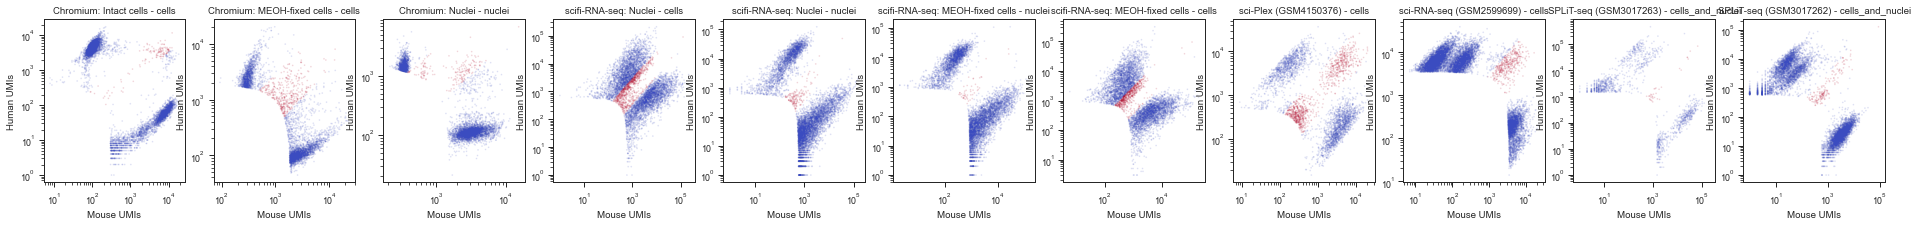

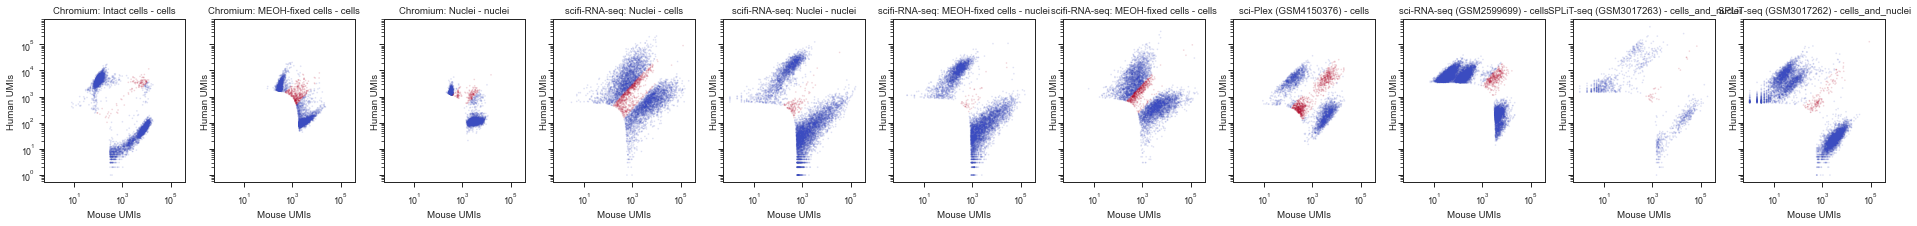

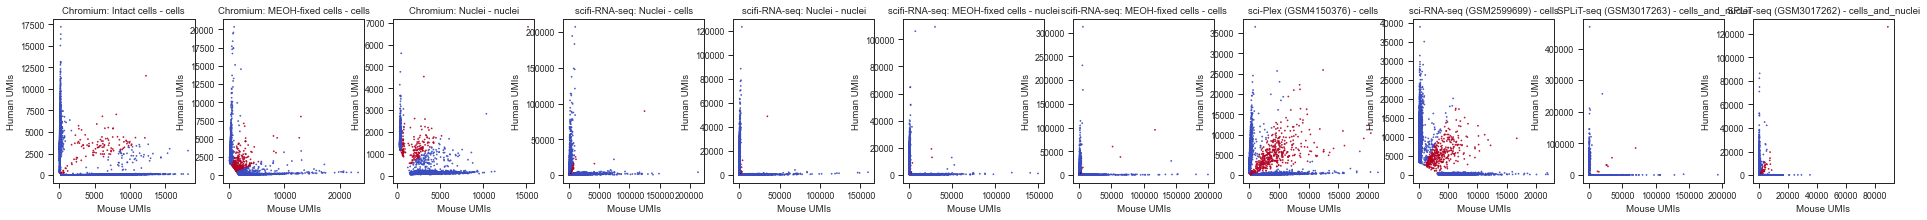

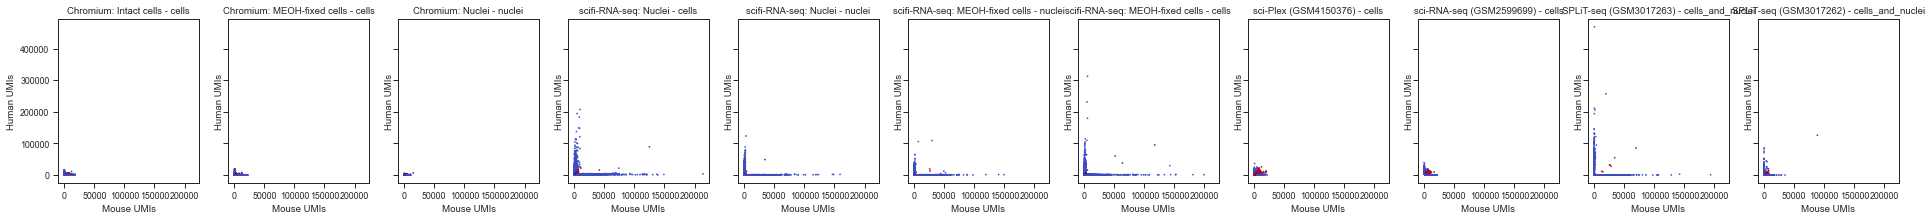

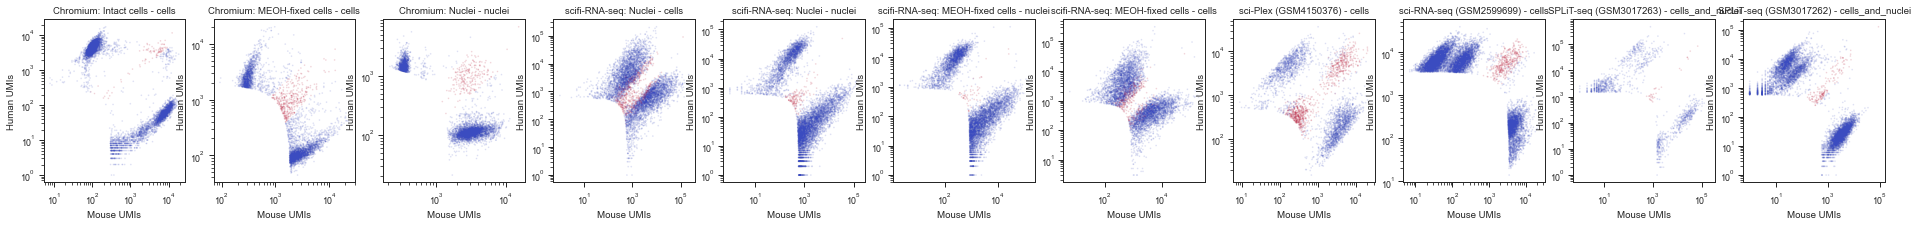

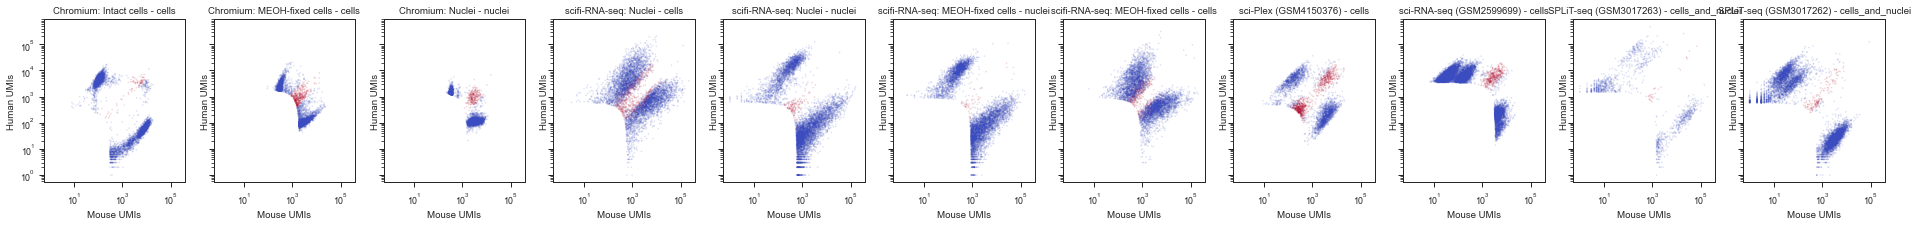

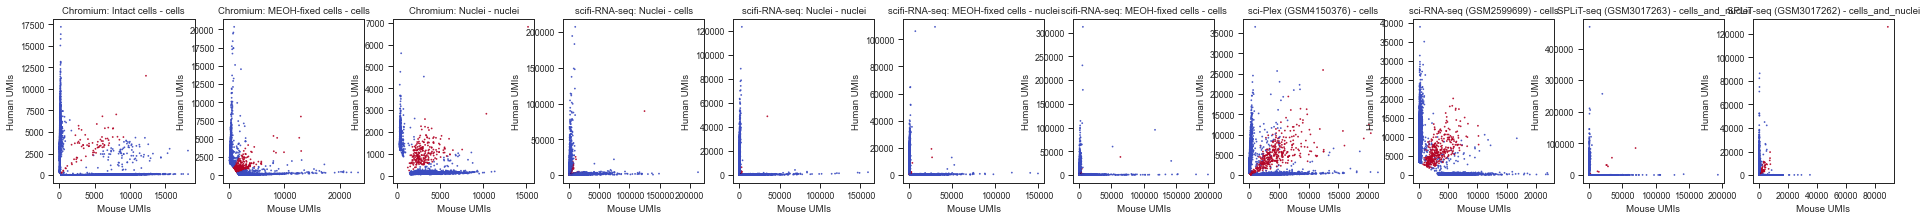

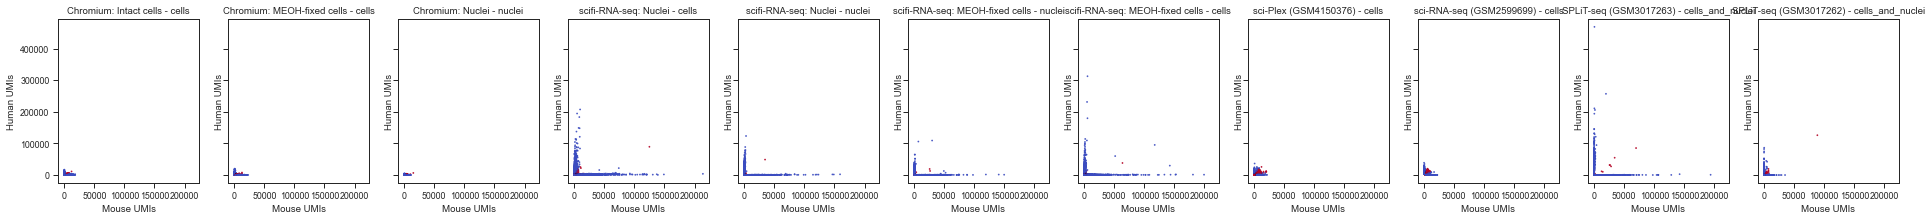

In [18]:
# Species mixing
for color in [
        "doublet",
        "doublet_norm"
]:
    for label in [
        "log",
        "linear"
    ]:
        for fixed_axis, l2 in [
                (False, "free_scale"),
                (True, "fixed")]:
            fig, axis = plt.subplots(
                1,
                n,
                figsize=(3 * n, 3 * 1),
                sharex=fixed_axis,
                sharey=fixed_axis,
            )
            axis = iter(axis.flatten())
            for i, (sample, material) in s.iterrows():
                m_a = metrics_f.query(
                    f"(sample == '{sample}') & (material_type == '{material}')"
                )
                m = m_a.nlargest(10000, columns="umi")
                kwds = dict(label=sample + " - " + material)
                s_kwds = dict(
                    alpha=0.1 if label == "log" else 0.8, s=1, rasterized=True
                )
                ax = next(axis)
                ax.set_title(kwds["label"])
                ax.scatter(m["mouse"], m["human"], c=m[color], cmap='coolwarm', **s_kwds, **kwds)
                if label == "log":
                    ax.loglog()
                ax.set_xlabel("Mouse UMIs")
                ax.set_ylabel("Human UMIs")
            fig.savefig(
                output_prefix + f"species_mixing.{label}.{l2}.separate.svg",
                **fig_kws,
            )

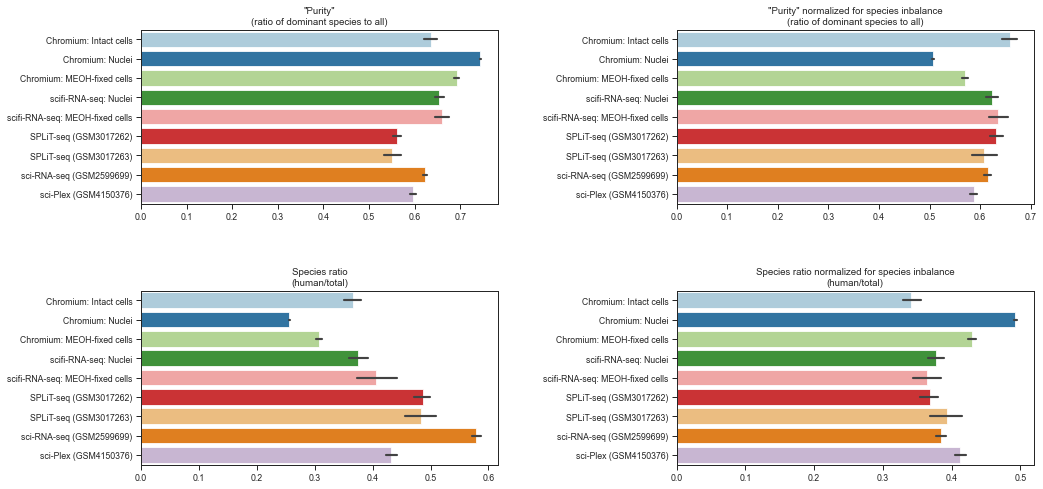

In [19]:
metrics = ['ratio', 'ratio_norm', 'sp_ratio', 'sp_ratio_norm']
labels = ['"Purity"\n(ratio of dominant species to all)', '"Purity" normalized for species inbalance\n(ratio of dominant species to all)',
          'Species ratio\n(human/total)', 'Species ratio normalized for species inbalance\n(human/total)']
fig, axes = plt.subplots(2, 2, figsize=(2 * 8, 2 * 4), gridspec_kw=dict(wspace=0.5, hspace=0.5))
for ax, met, lab in zip(axes.flat, metrics, labels):
    sns.barplot(data=metrics_fm.query("doublet == 1"), y='sample', x=met, orient='horiz', ax=ax)
    ax.set(title=lab, xlabel=None, ylabel=None)
fig.savefig(
    output_prefix + f"species_mixing.purity.svg",
    **fig_kws,
)

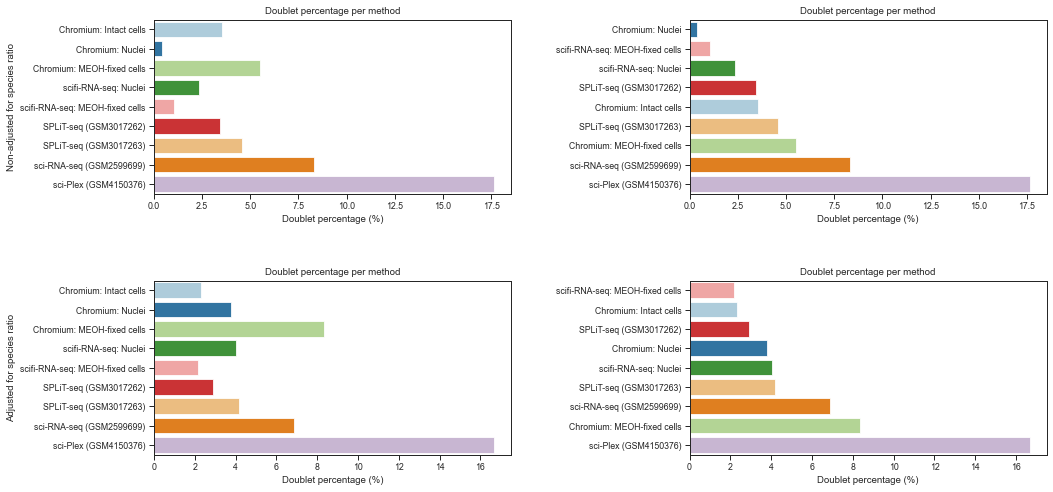

In [20]:
total = metrics_fm['sample'].value_counts()
d = (metrics_fm['doublet'].replace(-1, 0).groupby(metrics_fm['sample'].values).sum() / total).rename("Doublet")
dnorm = (metrics_fm['doublet_norm'].replace(-1, 0).groupby(metrics_fm['sample'].values).sum() / total).rename("Doublet")


fig, axes = plt.subplots(2, 2, figsize=(2 * 8, 2 * 4), gridspec_kw=dict(wspace=0.5, hspace=0.5))
for ax, df in zip(axes, [d, dnorm]):
    sns.barplot(x=df * 100, y=df.index, orient='horiz', ax=ax[0])
    ds = df.sort_values() * 100
    pal = np.array(sns.color_palette())[df.argsort().values]
    sns.barplot(x=ds, y=ds.index.tolist(), orient='horiz', ax=ax[1], palette=pal)
for ax in axes.flat:
    ax.set(title="Doublet percentage per method", xlabel="Doublet percentage (%)")
axes[0][0].set_ylabel("Non-adjusted for species ratio")
axes[1][0].set_ylabel("Adjusted for species ratio")
fig.savefig(
    output_prefix + f"species_mixing.doublet_percentage.svg",
    **fig_kws,
)

In [21]:
print(metrics_f['sample'].value_counts().sort_index())
print(metrics_fm['sample'].value_counts().sort_index())

Chromium: Intact cells              7097
Chromium: Nuclei                    4857
Chromium: MEOH-fixed cells          4516
scifi-RNA-seq: Nuclei              13708
scifi-RNA-seq: MEOH-fixed cells    12574
SPLiT-seq (GSM3017262)              7054
SPLiT-seq (GSM3017263)              1252
sci-RNA-seq (GSM2599699)           19574
sci-Plex (GSM4150376)               3676
Name: sample, dtype: int64
Chromium: Intact cells             2994
Chromium: Nuclei                   3523
Chromium: MEOH-fixed cells         2878
scifi-RNA-seq: Nuclei              8272
scifi-RNA-seq: MEOH-fixed cells    7337
SPLiT-seq (GSM3017262)             3443
SPLiT-seq (GSM3017263)              526
sci-RNA-seq (GSM2599699)           8874
sci-Plex (GSM4150376)              1944
Name: sample, dtype: int64
